# Exercise 4

## Write a discrete event simulation program for a blocking system, i.e. a system with m service units and no waiting room. The offered traffic A is the product of the mean arrival rate and the mean service time.

### 1. The arrival process is modelled as a Poisson process. Report the fraction of blocked customers, and a confidence interval for this fraction. Choose the service time distribution as exponential. Parameters: m = 10, mean service time = 8 time units, mean time between customers = 1 time unit (corresponding to an offered traffic of 8 Erlang), 10 x 10.000 customers. This system is sufficiently simple such that the analytical solution is known. See the last slide for the solution. Verify your simulation program using this knowledge.

In this assignment, we are supposed to simulate a blocking system with no waiting room, meaning arriving customers either get served or blocked, if no servers are avalaible. We are given:

- $m=10$ servers
- mean service time $=8$
- interarrival time $= 1$
- we should run with 10 batches of 10.000 customers each
- service times are exponential

Using this information, we can begin modelling the problem as a discrete event simulation. I use Poisson-distributed arrivals and exponential arrival times, whereof I can calculate how many customers get blocked when entering the system:

In [12]:
import numpy as np
import heapq
import math
from scipy.stats import expon, erlang, bernoulli, norm, pareto
import matplotlib.pyplot as plt
from enum import StrEnum
from heapq import heappush, heappop, heapify
np.random.seed(1234)

class Event(StrEnum):
    ARRIVED = "Arrived"
    SERVICED = "Serviced"
    BLOCKED = "Blocked"
    

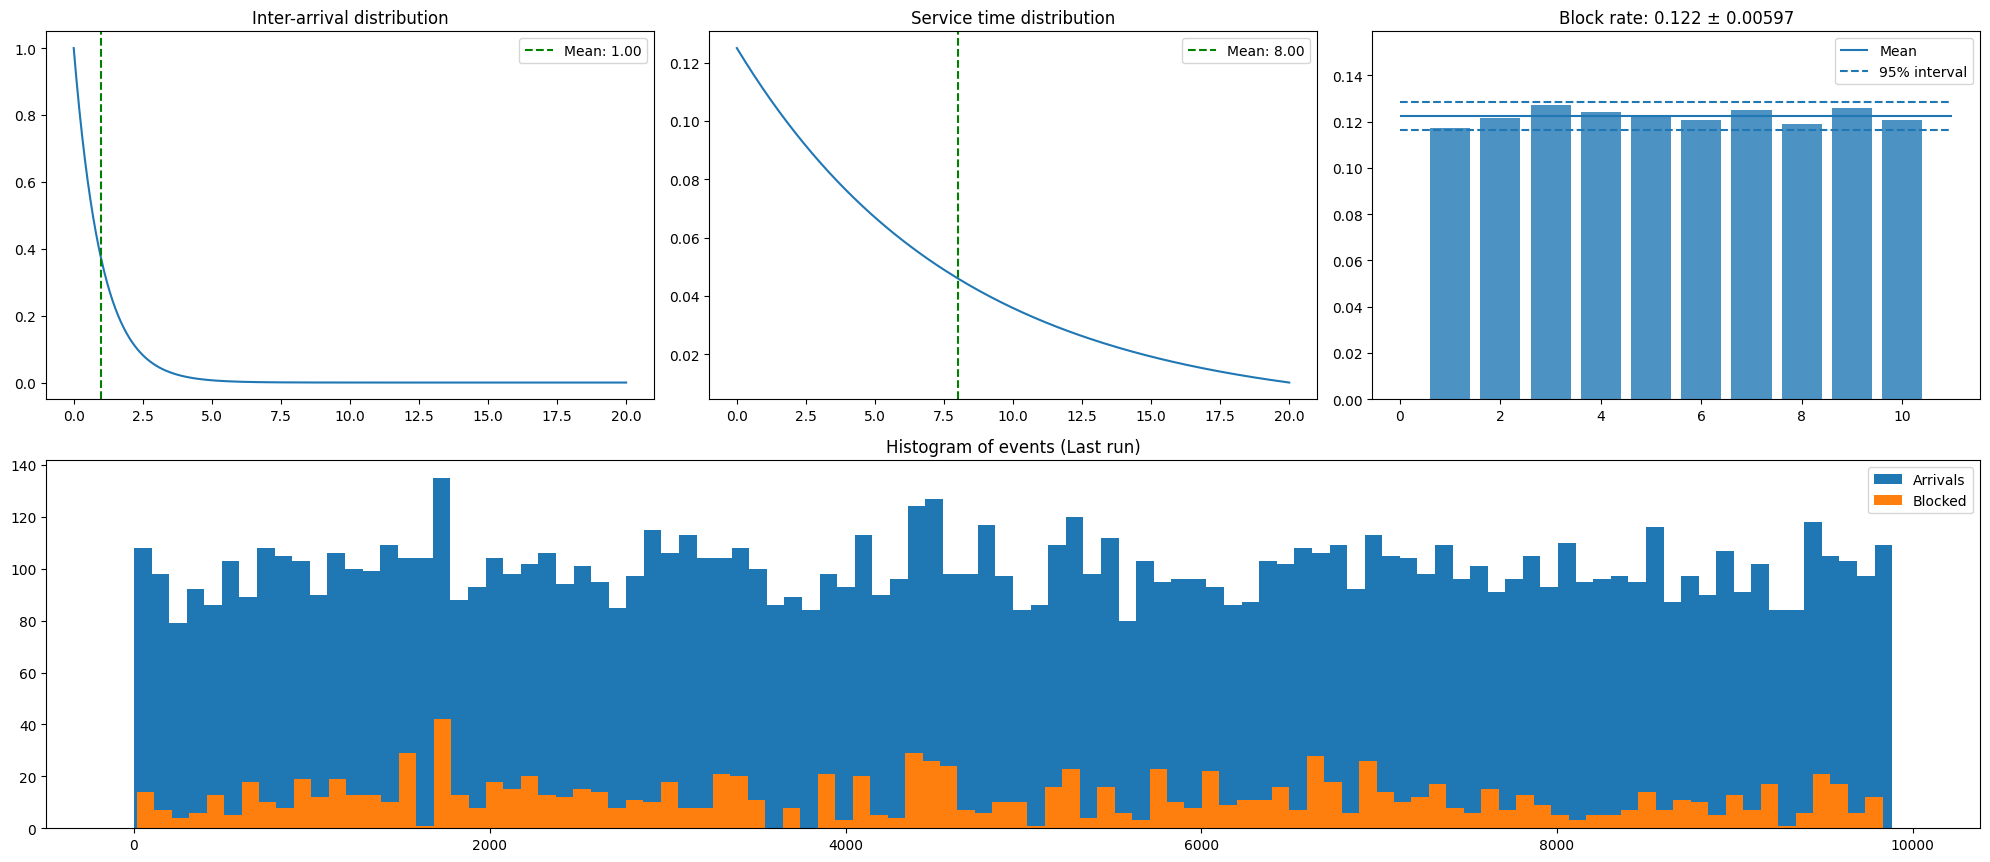


Estimated Blocking Probability: 0.1224
95% Confidence Interval: (0.1164, 0.1283)


In [23]:
def simulate_system(inter_arrival_dist, service_time_dist, m=10, n_customers=10_000):

    service_units = [i for i in range(m)]

    arrival_times = np.cumsum(inter_arrival_dist.rvs(size=n_customers))

    events = [(time.item(), Event.ARRIVED) for time in arrival_times]
    heapify(events)

    n_serviced = 0
    n_blocked = 0
    events_processed = []

    while events:
        event = heappop(events)
        
        match event:
            case (time, Event.ARRIVED):
                if service_units:
                    new_event = (
                        time + service_time_dist.rvs(),
                        Event.SERVICED,
                        service_units.pop(),
                    )                
                else:
                    new_event = (
                        time,
                        Event.BLOCKED,
                    )
                heappush(events, new_event)
            case (_, Event.SERVICED, service_unit):
                service_units.append(service_unit)
                n_serviced += 1
            case (_, Event.BLOCKED):
                n_blocked += 1
        
        events_processed.append(event)

    return n_serviced, n_blocked, events_processed


def simulate_and_print_stats(inter_arrival_dist, service_time_dist, iterations=10, m=10, n_customers=10_000):
    blocked = np.empty(iterations)
    for i in range(iterations):
        _, n_blocked, events = simulate_system(inter_arrival_dist, service_time_dist, m, n_customers)
        blocked[i] = n_blocked

    blocked /= n_customers

    mean = np.mean(blocked)
    std = np.std(blocked)
    ci_low = mean - 1.96 * std
    ci_high = mean + 1.96 * std

    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(2, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = fig.add_subplot(gs[0, 2])

    xs = np.linspace(0, 20, 200)

    ax1.set_title("Inter-arrival distribution")
    ax1.plot(xs, inter_arrival_dist.pdf(xs))
    m_arrival = inter_arrival_dist.mean()
    ax1.axvline(m_arrival, color="g", linestyle="--", label=f"Mean: {m_arrival:.2f}")
    ax1.legend()

    ax2.set_title("Service time distribution")
    ax2.plot(xs, service_time_dist.pdf(xs))
    m_service = service_time_dist.mean()
    ax2.axvline(m_service, color="g", linestyle="--", label=f"Mean: {m_service:.2f}")
    ax2.legend()

    arrivals = [event[0] for event in events if event[1] == Event.ARRIVED]
    blocks = [event[0] for event in events if event[1] == Event.BLOCKED]
    ax3.set_title("Histogram of events (Last run)")
    ax3.hist(arrivals, bins=100, label="Arrivals")
    ax3.hist(blocks, bins=100, label="Blocked")
    ax3.legend()
    
    ax4.set_title(f"Block rate: {mean:.3f} ± {1.96 * std:.5f}")
    ax4.bar(np.arange(iterations) + 1, blocked, alpha=0.8)
    ax4.hlines(mean, xmin=0, xmax=iterations + 1, label="Mean")
    ax4.hlines(ci_high, xmin=0, xmax=iterations + 1, linestyles="--", label="95% interval")
    ax4.hlines(ci_low, xmin=0, xmax=iterations + 1, linestyles="--")
    ax4.set_ylim(0, 1.25 * np.max(blocked))
    ax4.legend()
    fig.tight_layout(rect=[0, 0.03, 1, 1])  
    plt.show()
    
    print("\nEstimated Blocking Probability: {:.4f}".format(mean))
    print("95% Confidence Interval: ({:.4f}, {:.4f})".format(ci_low, ci_high))

inter_arrival_dist = expon(scale=1)
service_time_dist = expon(scale=8)

mean = simulate_and_print_stats(inter_arrival_dist, service_time_dist)


We observe the distribution of inter-arrivals, having a mean of 1, following an exponential distribution. Furthermore, the distribution of the service time also follows an exponential distribution, with a mean of 8. The blocking rate of the $m=10$ servers can be observed to the right plot, wherein the average blocking rate is 12.04%. This means that circa 12% of customers were blocked when arriving, meaning 12% of customers came at a time where all servers $m$ were occupied and thus, these customers were not served. The 95%-confidence also lays nicely around 12%, meaning we are quite certain that between 11% - 13% of customers would in general be blocked when arriving. When we see in the large plot that this blocking percentages fluctuates and different amounts of customers arrive at different time - some coming in bulk which puts more strain on the system.

Now, when comparing it to the calculation for the analytical Erlang B result:

In [25]:
A = 8
m = 10

def factorial(n):
    if n in (0, 1):
        return 1
    return n * factorial(n - 1)

a = A ** m / factorial(m)
b = sum(A ** i / factorial(i) for i in range(m + 1))

print(f"Analytical Erlang B blocking probability: {a / b:.4f}")
print(f"Absolute error vs simulation: {(a / b ) - 0.1224 :.6f}")

Analytical Erlang B blocking probability: 0.1217
Absolute error vs simulation: -0.000739


Since there is only an absolute error of -0.0007, the simulation can be deemed a sucess, since it produced results are consistent with the theoretical Erland B model.

## 2. The arrival process is modelled as a renewal process using the same parameters as in Part 1 when possible. Report the fraction of blocked customers, and a confidence interval for this fraction for at least the following two cases

### (a) Experiment with Erlang distributed inter arrival times The Erlang distribution should have a mean of 1

$\textbf{(a)}$ To explore the effect of more regular arrival patterns, we simulate the same blocking system using Erlang-distributed interarrival times, specifically an Erlang(2, 2) distribution. This maintains the same mean of 1 as the original exponential case but with lower variability. The rest of the system parameters remain unchanged.

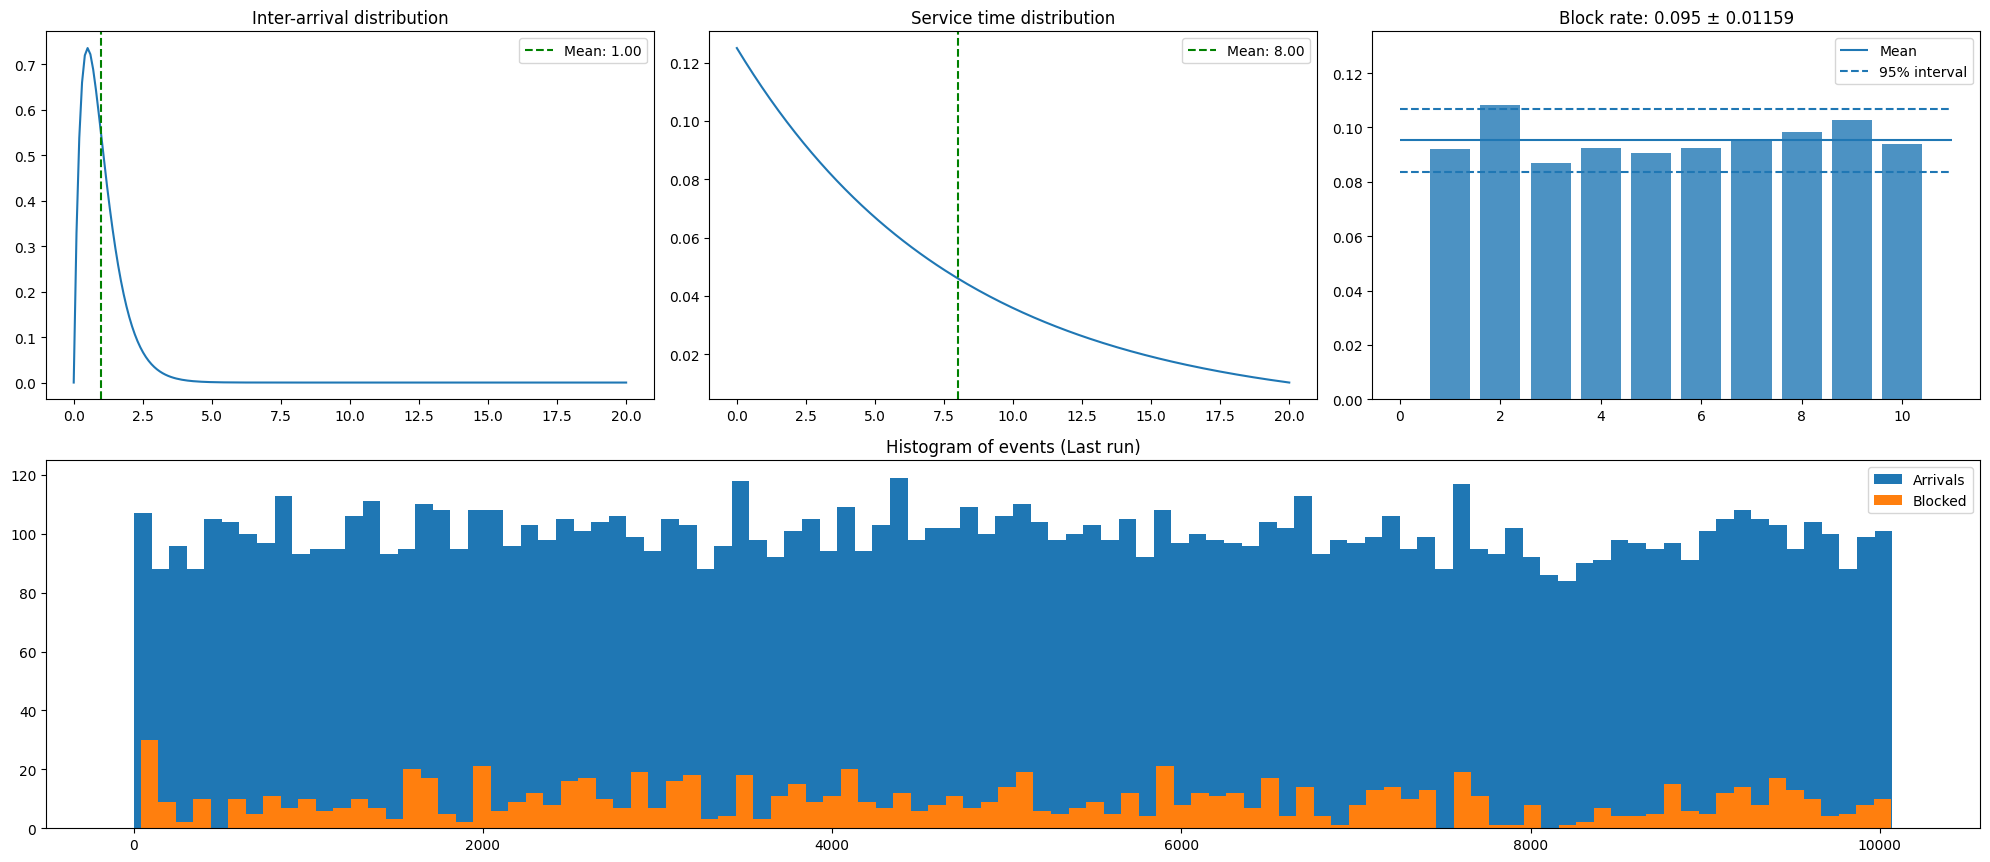


Estimated Blocking Probability: 0.0954
95% Confidence Interval: (0.0838, 0.1069)


In [26]:
inter_arrival_dist = erlang(a=2, scale=1/2)
service_time_dist = expon(scale=8)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

The simulation shows a blocking probability of approximately 9.05%, with a 95% confidence interval ranging from 8.38% to 10.69%. This is lower than the Poisson arrival case (12%), indicating that reduced arrival variability in the Erlang distribution leads to fewer customers arriving in bursts and thus, reduces the chance of all servers being occupied simultaneously.

### (b) hyper exponential inter arrival times. The parameters for the hyper exponential distribution should be p1 = 0.8, λ1 = 0.8333, p2 = 0.2, λ2 = 5.0.

$\textbf{(b)}$ Now, we will utilize hyper exponential arrival times in the simulation. We are given the values: $p_1=0.8$, $p_2 = 0.2$, $\lambda_1=0.8333$, and $\lambda_2=5$:

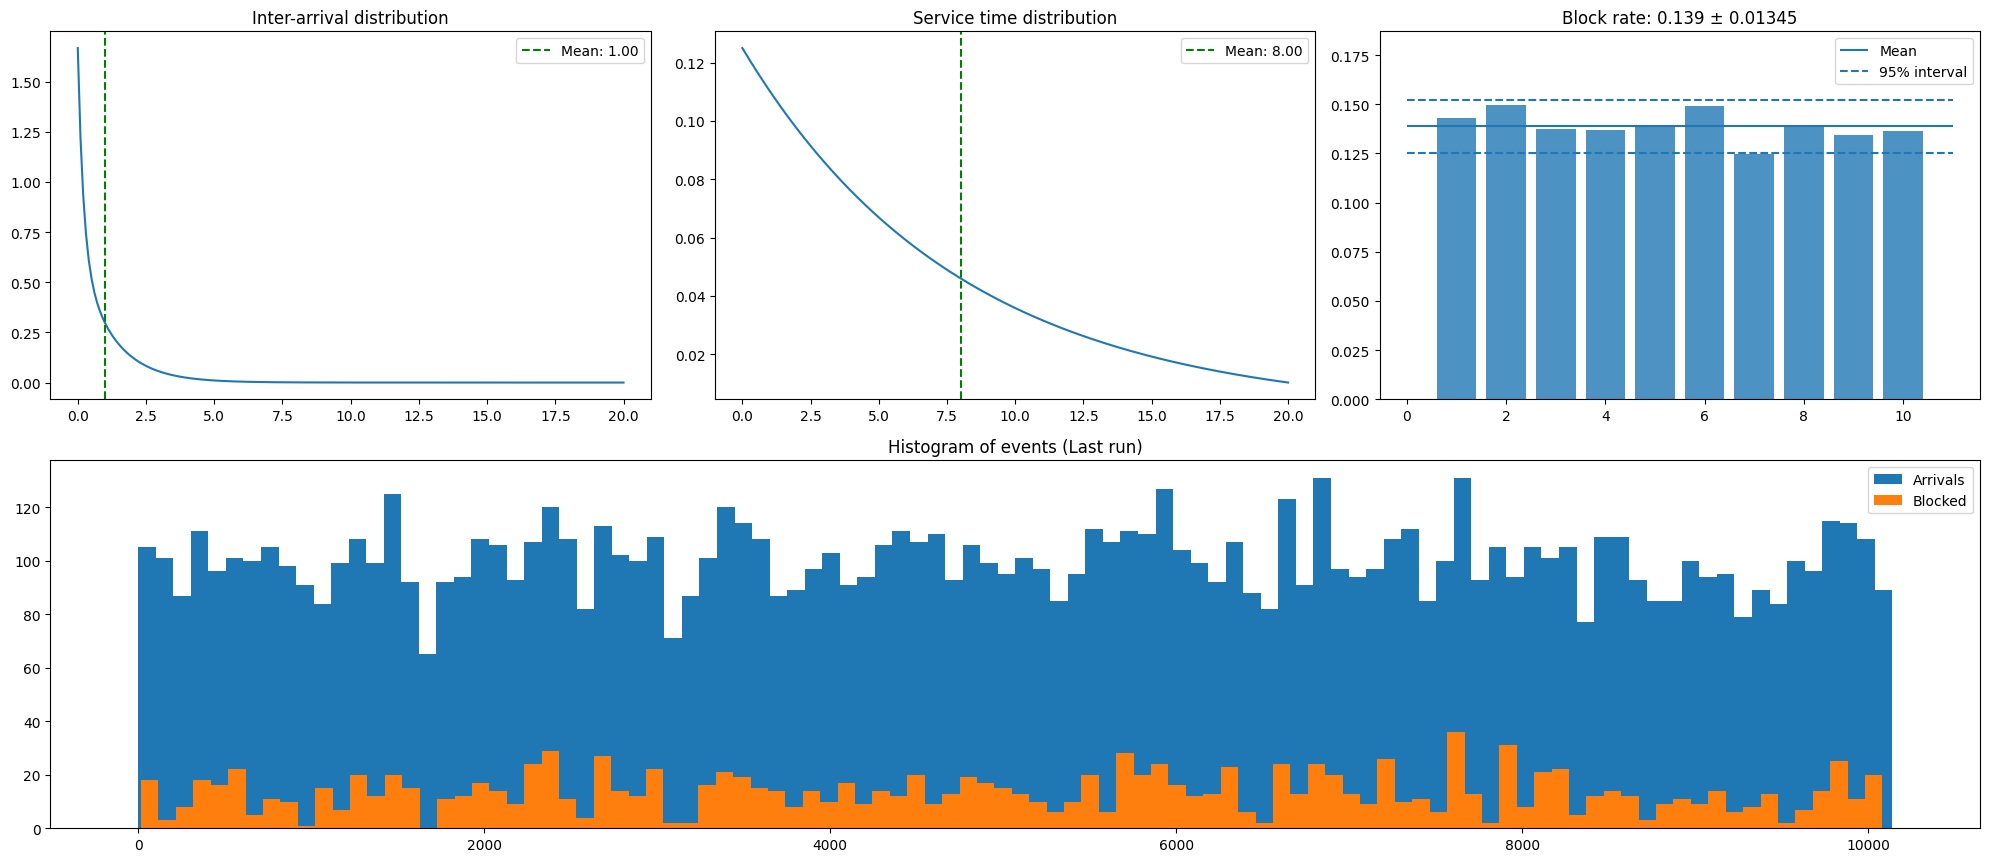


Estimated Blocking Probability: 0.1389
95% Confidence Interval: (0.1254, 0.1523)


In [27]:
class hyperexpon:
    def __init__(self, p1, lambda1, lambda2):
        self.p1 = p1
        self.expon1 = expon(scale=1/lambda1)
        self.expon2 = expon(scale=1/lambda2)

    def mean(self):
        return self.p1 * self.expon1.mean() + (1 - self.p1) * self.expon2.mean()

    def rvs(self, size=1):
        mask = bernoulli.rvs(p=self.p1, size=size) == 1
        expon1 = self.expon1.rvs(size=size)
        expon2 = self.expon2.rvs(size=size)

        return np.where(mask, expon1, expon2)
    
    def pdf(self, xs):
        return self.p1 * self.expon1.pdf(xs) + (1 - self.p1) * self.expon2.pdf(xs)

inter_arrival_dist = hyperexpon(p1=0.8, lambda1=0.8333, lambda2=5.0)
service_time_dist = expon(scale=8)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

This yields a blocking probability of circa 13.89%, which is somewhat higher than both the exponential and Erland cases, reflecting the increased variability in the arrival process. Specifically, with hyper exponential inter arrival times results in more customers arriving in short time frames, increasing the likelihood of customers not being served (i.e., the blocking probability).

## 3. The arrival process is again a Poisson process like in Part 1. Experiment with different service time distributions with thesame m ean service time and m as in Part 1 and Part 2.

### (a) Constant service time

$\textbf{(a)}$ The arrival process is once again a Poisson process. We set the average service time to a constant, 8.

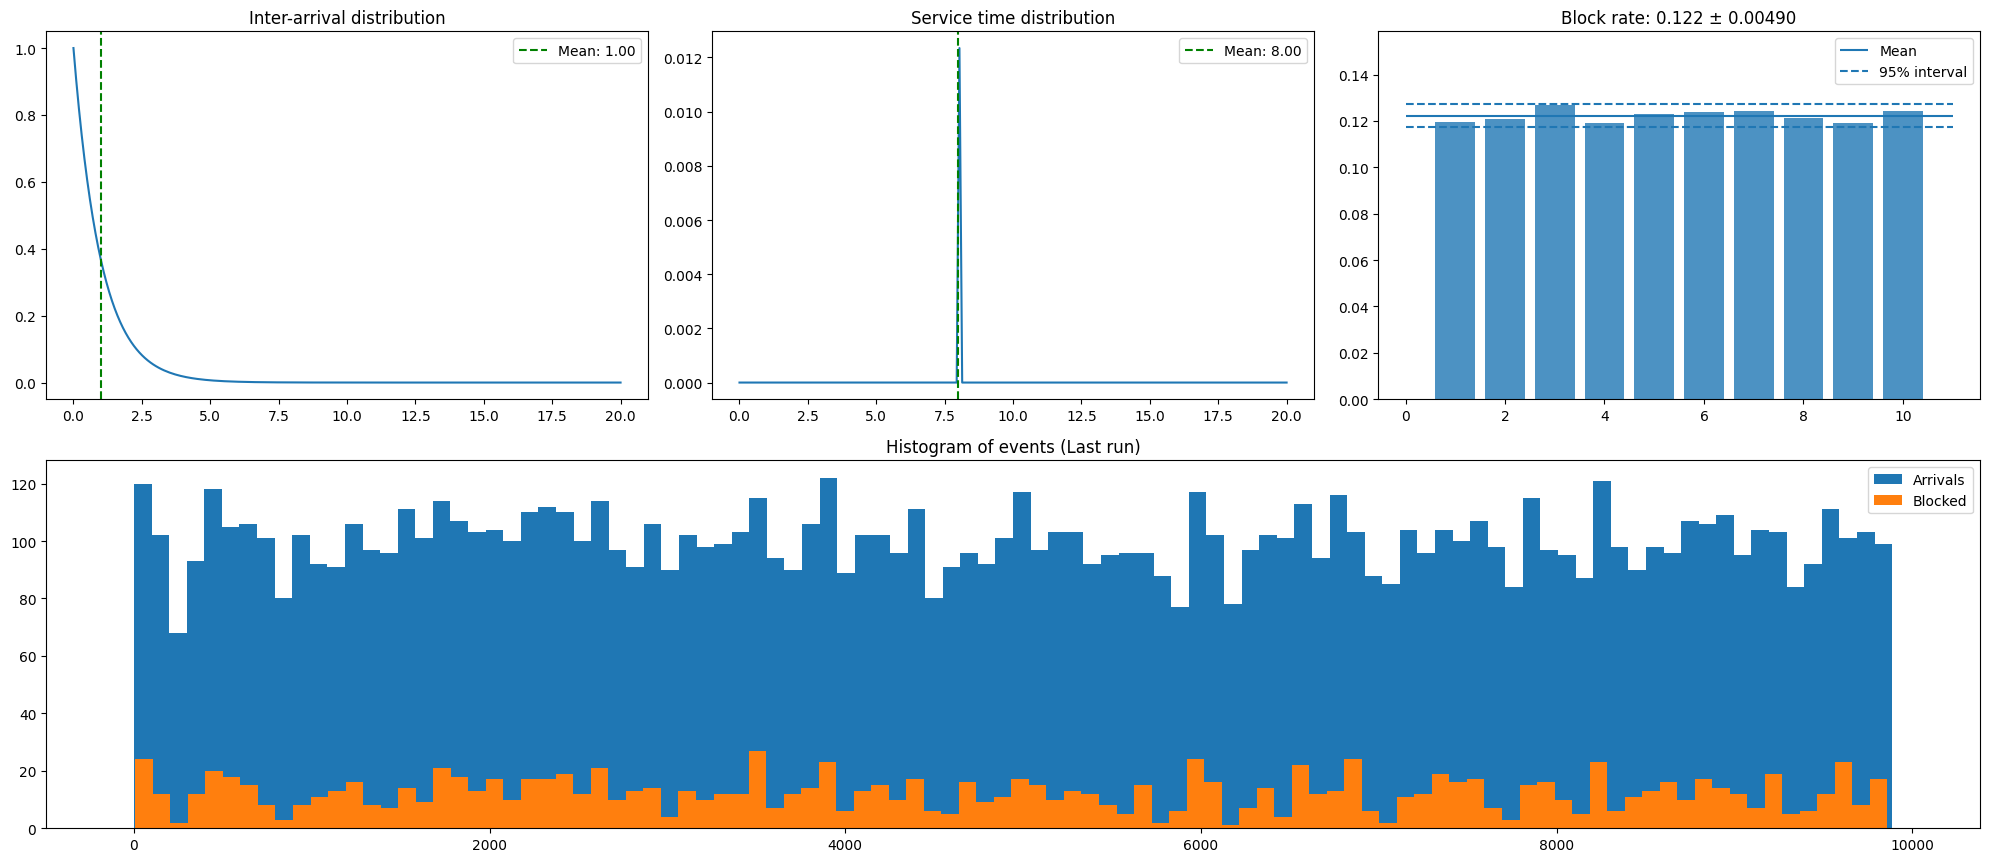


Estimated Blocking Probability: 0.1222
95% Confidence Interval: (0.1173, 0.1271)


In [28]:
inter_arrival_dist = expon(scale=1)
service_time_dist = norm(loc=8, scale=0.01) # ~constant service time

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

This is quite similar to the exponential case, it makes sense since the mean service time is the same. While this case reduces service variability, it does not affect the inherent randomness of the arrivals.

### (b) Pareto distributed service times with at least k = 1.05 and k = 2.05.

$\textbf{(b)}$ Now, we set the service time to be both Pareto distributed with atleast $k_1=1.05$ and maximumally $k_2=2.05$

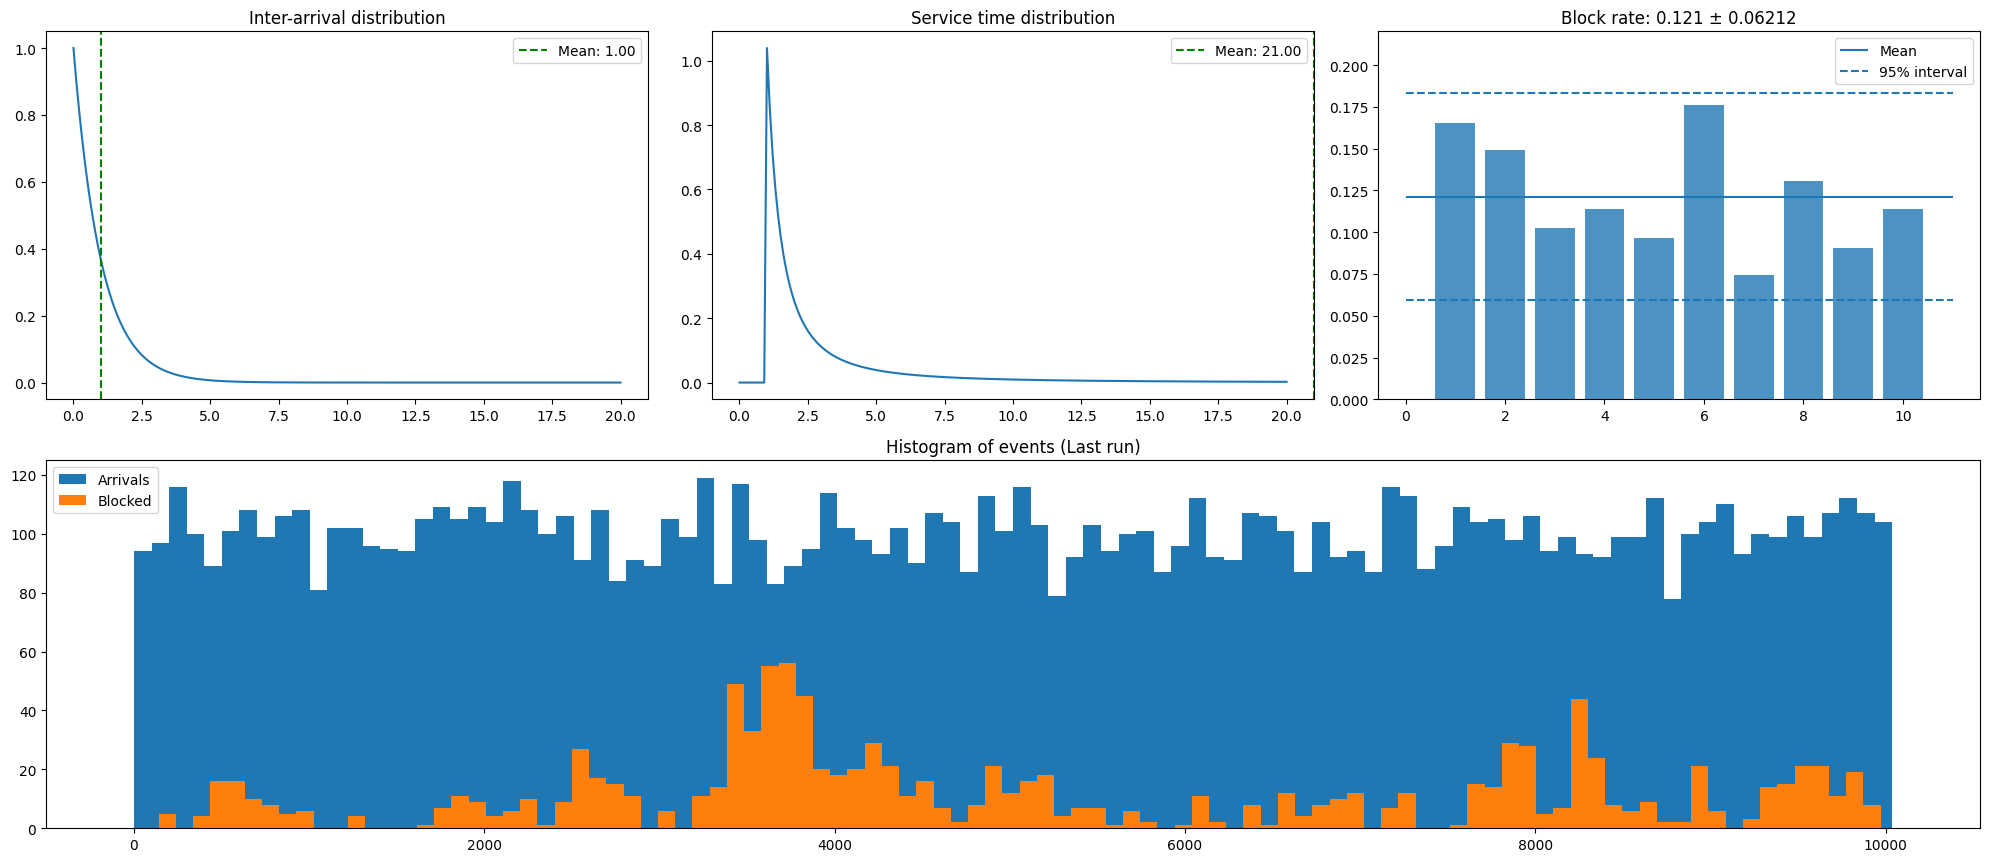


Estimated Blocking Probability: 0.1213
95% Confidence Interval: (0.0592, 0.1834)


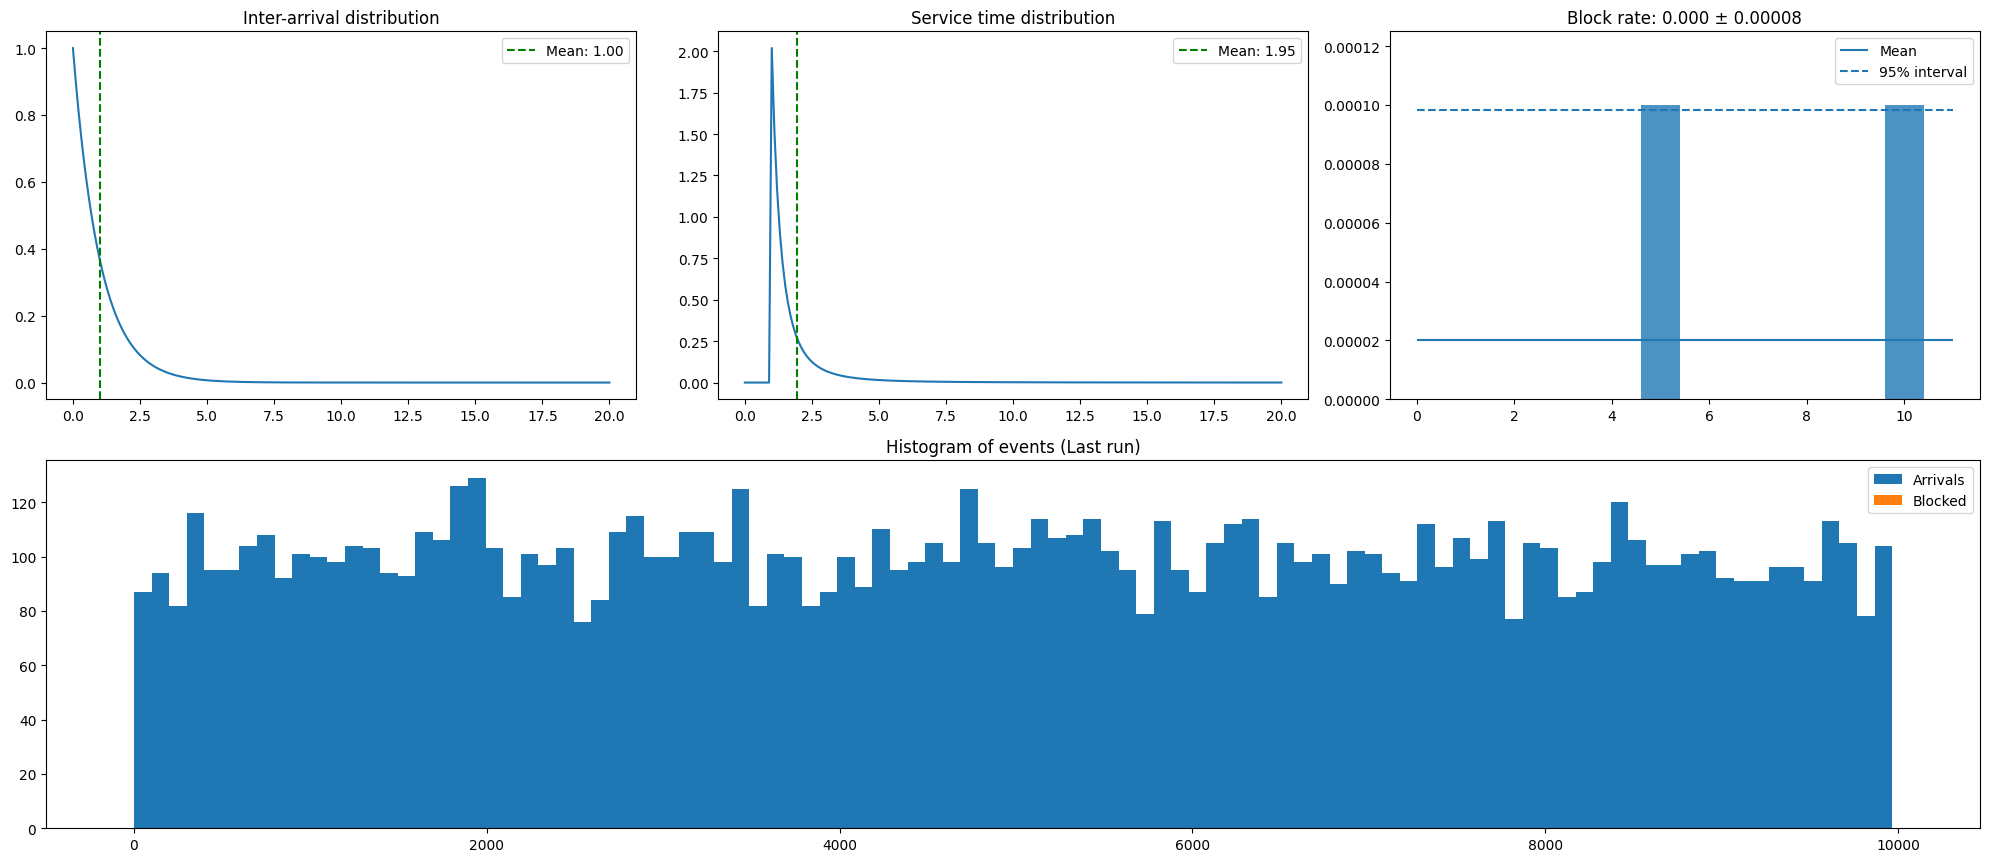


Estimated Blocking Probability: 0.0000
95% Confidence Interval: (-0.0001, 0.0001)


In [32]:
# 4.3.b
inter_arrival_dist = expon(scale=1)
service_time_dist = pareto(b=1.05)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

service_time_dist = pareto(b=2.05)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

With $k=1.05$, the blocking probability becomes apparently smaller. This is due to fewer arrivals happening during busy periods and thus, less blocking. However, as for $k=2.05$, the blocking probability becomes almost 0, with virtually no blocking.

### (c) Choose one or two other distributions

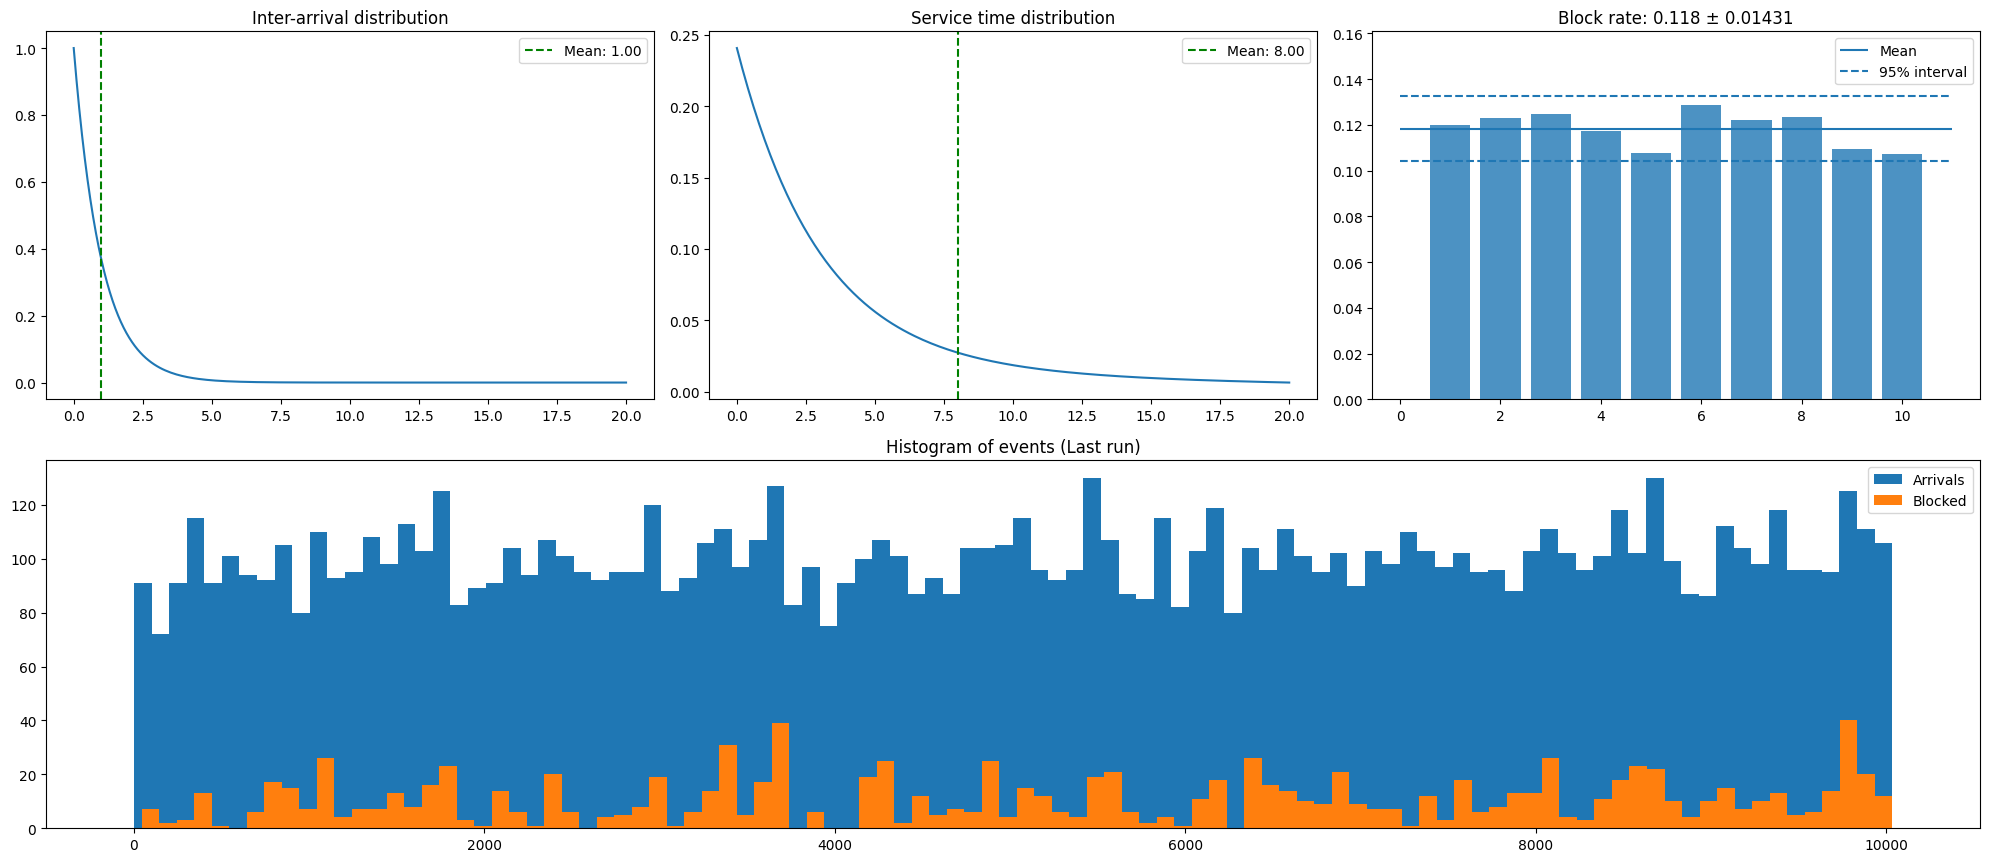


Estimated Blocking Probability: 0.1183
95% Confidence Interval: (0.1040, 0.1327)


In [33]:
inter_arrival_dist = expon(scale=1)
service_time_dist = hyperexpon(1/3, 1/18, 1/3)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)